# Anomalous SST Trend 

## $$Historical - \overline{PIC}  = Anomaly$$

### `pip install dask --force-reinstall` in terminal to fix error when opening ds
`Python Xarray ValueError: unrecognized chunk manager dask - must be one of: []`

In [1]:
import xarray as xr 
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
historical = xr.open_mfdataset('/work/Shanice.Bailey/ESM4/historical_1850-2014/ocean_*.nc', decode_times=False)

In [3]:
pic = xr.open_mfdataset('/work/Shanice.Bailey/ESM4/PIC/ocean_*.tos.nc', decode_times=False)

In [4]:
historical

<xarray.Dataset> Size: 100GB
Dimensions:     (time: 60225, nv: 2, yh: 576, xh: 720)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
  * time        (time) float64 482kB 0.5 1.5 2.5 ... 6.022e+04 6.022e+04
  * xh          (xh) float64 6kB -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * yh          (yh) float64 5kB -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Data variables:
    average_DT  (time) float64 482kB dask.array<chunksize=(1825,), meta=np.ndarray>
    average_T1  (time) float64 482kB dask.array<chunksize=(1825,), meta=np.ndarray>
    average_T2  (time) float64 482kB dask.array<chunksize=(1825,), meta=np.ndarray>
    time_bnds   (time, nv) float64 964kB dask.array<chunksize=(1825, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 100GB dask.array<chunksize=(1825, 576, 720), meta=np.ndarray>
Attributes:
    filename:            ocean_daily_cmip.18500101-18541231.tos.nc
    title:               ESM4_esm-hist_D1
    associated_files:    areacello: 18500101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

In [5]:
pic

<xarray.Dataset> Size: 200GB
Dimensions:     (time: 120450, nv: 2, yh: 576, xh: 720)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
  * time        (time) float64 964kB 0.5 1.5 2.5 ... 1.825e+05 1.825e+05
  * xh          (xh) float64 6kB -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * yh          (yh) float64 5kB -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Data variables:
    average_DT  (time) float64 964kB dask.array<chunksize=(1825,), meta=np.ndarray>
    average_T1  (time) float64 964kB dask.array<chunksize=(1825,), meta=np.ndarray>
    average_T2  (time) float64 964kB dask.array<chunksize=(1825,), meta=np.ndarray>
    time_bnds   (time, nv) float64 2MB dask.array<chunksize=(1825, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 200GB dask.array<chunksize=(1825, 576, 720), meta=np.ndarray>
Attributes:
    filename:            ocean_daily_cmip.00010101-00051231.tos.nc
    title:               ESM4_esm-piControl_D
    associated_files:    areacello: 00010101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

Got this warning during PIC download 

In [38]:
#see what local dask is doing in the background 
from dask.distributed import LocalCluster, Client
import dask

with dask.config.set(**{"distributed.dashboard.link": "/user/stb/proxy/{port}/status"}):
    cluster = LocalCluster()
    client = Client(cluster)

/home/Shanice.Bailey/.local/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38819 instead
  warnings.warn(


In [39]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:38819/status,
Dashboard: http://127.0.0.1:38819/status,Workers: 4
Total threads: 16,Total memory: 502.62 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43191,Workers: 4
Dashboard: http://127.0.0.1:38819/status,Total threads: 16
Started: Just now,Total memory: 502.62 GiB
Comm: tcp://127.0.0.1:42563,Total threads: 4
Dashboard: http://127.0.0.1:35823/status,Memory: 125.66 GiB
Nanny: tcp://127.0.0.1:40357,


In [8]:
gom = dict(xh=slice(-100,-80), yh=slice(21,31))
pic_gom1 = pic.tos.sel(**gom)

hist_gom1 = historical.tos.sel(**gom).assign_coords({'time':pd.date_range('1850-01-01', periods=60225, freq='D')})
pic_gom = pic_gom1.assign_coords({'time':np.tile(np.arange(1,366), 330)})

In [13]:
pic_gom

<xarray.DataArray 'tos' (time: 120450, yh: 23, xh: 40)> Size: 443MB
dask.array<getitem, shape=(120450, 23, 40), dtype=float32, chunksize=(1825, 23, 40), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 184B 21.1 21.53 21.96 22.4 ... 29.37 29.81 30.24 30.67
  * time     (time) int64 964kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

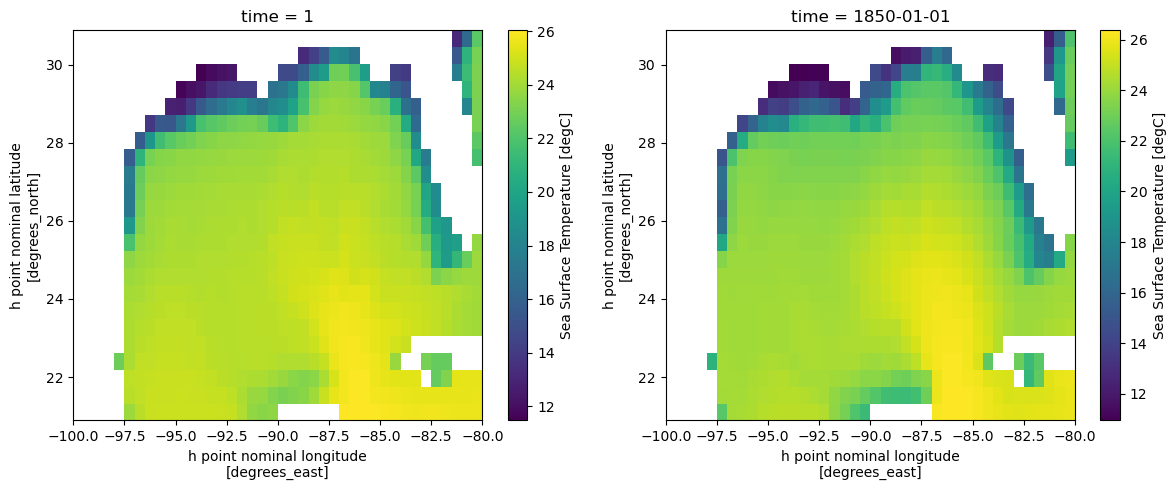

In [10]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
pic_gom[0].plot(ax=ax0)
hist_gom1[0].plot(ax=ax1)
plt.tight_layout();

In [15]:
#Compute daily climatology of PIC sst's
pic_clim = pic_gom.groupby('time').mean('time')

In [16]:
pic_clim

<xarray.DataArray 'tos' (time: 365, yh: 23, xh: 40)> Size: 1MB
dask.array<stack, shape=(365, 23, 40), dtype=float32, chunksize=(1, 23, 40), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 184B 21.1 21.53 21.96 22.4 ... 29.37 29.81 30.24 30.67
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [17]:
#create dummy array to fill out rest of 2024
darr = xr.DataArray(data=np.empty((40,23,40)),
                    coords=({'time':pd.date_range('2014-11-22', periods=40, freq='D'),
                             'yh':hist_gom1.yh,
                             'xh':hist_gom1.xh}),
                    dims=('time', 'yh', 'xh'))
darr[:] = np.nan

In [18]:
# extend historical sst to end of 2014 so that you can take daily climatology
hist_gom = xr.concat([hist_gom1, darr], dim='time')

In [19]:
hist_clim = hist_gom.groupby('time.dayofyear').mean('time')

In [20]:
hist_clim

<xarray.DataArray 'tos' (dayofyear: 366, yh: 23, xh: 40)> Size: 3MB
dask.array<stack, shape=(366, 23, 40), dtype=float64, chunksize=(1, 23, 40), chunktype=numpy.ndarray>
Coordinates:
  * xh         (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh         (yh) float64 184B 21.1 21.53 21.96 22.4 ... 29.81 30.24 30.67
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [21]:
pic_clim

<xarray.DataArray 'tos' (time: 365, yh: 23, xh: 40)> Size: 1MB
dask.array<stack, shape=(365, 23, 40), dtype=float32, chunksize=(1, 23, 40), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 184B 21.1 21.53 21.96 22.4 ... 29.37 29.81 30.24 30.67
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [61]:
pcopy = pic_clim[-1]
pic_clim_ext = xr.concat([pic_clim, pcopy], dim='time')

In [68]:
hist_clim

<xarray.DataArray 'tos' (dayofyear: 366, yh: 23, xh: 40)> Size: 3MB
dask.array<stack, shape=(366, 23, 40), dtype=float64, chunksize=(1, 23, 40), chunktype=numpy.ndarray>
Coordinates:
  * xh         (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh         (yh) float64 184B 21.1 21.53 21.96 22.4 ... 29.81 30.24 30.67
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [33]:
#create dummy array to fill out rest of 2024
hclim_ptime = xr.DataArray(data=hist_clim[:-1].drop_vars('dayofyear').data,
                            coords=({'time':pic_clim.time,
                             'yh':pic_clim.yh,
                             'xh':pic_clim.xh}),
                            dims=('time', 'yh', 'xh'),
                            name='tos')

In [40]:
hclim_ptime.load()

<xarray.DataArray 'tos' (time: 365, yh: 23, xh: 40)> Size: 3MB
array([[[        nan,         nan,         nan, ..., 25.68983358,
         25.69112322, 25.69305967],
        [        nan,         nan,         nan, ..., 25.60339958,
         25.61296488, 25.62494179],
        [        nan,         nan,         nan, ..., 25.52615295,
         25.55968314, 25.5696028 ],
        ...,
        [        nan,         nan,         nan, ..., 15.31420759,
         20.0393923 , 22.50596615],
        [        nan,         nan,         nan, ..., 13.86825373,
         19.12273553, 22.34812572],
        [        nan,         nan,         nan, ..., 12.128455  ,
         15.20645036, 21.41073971]],

       [[        nan,         nan,         nan, ..., 25.65941124,
         25.66378726, 25.66762568],
        [        nan,         nan,         nan, ..., 25.57522929,
         25.58702117, 25.6012641 ],
        [        nan,         nan,         nan, ..., 25.50212956,
         25.53709821, 25.54803677],
...
        [        nan,         nan,         nan, ..., 15.34195671,
         20.08613276, 22.56317512],
        [        nan,         nan,         nan, ..., 13.89508521,
         19.17518128, 22.39894585],
        [        nan,         nan,         nan, ..., 12.18583554,
         15.26020344, 21.46381956]],

       [[        nan,         nan,         nan, ..., 25.72523877,
         25.72470188, 25.72511488],
        [        nan,         nan,         nan, ..., 25.63828936,
         25.6434314 , 25.65176927],
        [        nan,         nan,         nan, ..., 25.55718552,
         25.58787625, 25.59748054],
        ...,
        [        nan,         nan,         nan, ..., 15.33705545,
         20.0681516 , 22.53865707],
        [        nan,         nan,         nan, ..., 13.88225102,
         19.15272583, 22.37840173],
        [        nan,         nan,         nan, ..., 12.15599717,
         15.24751527, 21.43559718]]])
Coordinates:
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * yh       (yh) float64 184B 21.1 21.53 21.96 22.4 ... 29.37 29.81 30.24 30.67
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25

In [41]:
pic_clim.load()

<xarray.DataArray 'tos' (time: 365, yh: 23, xh: 40)> Size: 1MB
array([[[       nan,        nan,        nan, ..., 25.739817 ,
         25.744434 , 25.753057 ],
        [       nan,        nan,        nan, ..., 25.648613 ,
         25.66503  , 25.68664  ],
        [       nan,        nan,        nan, ..., 25.583452 ,
         25.634235 , 25.649979 ],
        ...,
        [       nan,        nan,        nan, ..., 15.581468 ,
         20.364218 , 22.870811 ],
        [       nan,        nan,        nan, ..., 14.2212   ,
         19.479033 , 22.718323 ],
        [       nan,        nan,        nan, ..., 12.716822 ,
         15.840177 , 21.857286 ]],

       [[       nan,        nan,        nan, ..., 25.718906 ,
         25.724287 , 25.733791 ],
        [       nan,        nan,        nan, ..., 25.628403 ,
         25.64516  , 25.666441 ],
        [       nan,        nan,        nan, ..., 25.559576 ,
         25.611044 , 25.62648  ],
...
        [       nan,        nan,        nan, ..., 15.602367 ,
         20.430752 , 22.93338  ],
        [       nan,        nan,        nan, ..., 14.247798 ,
         19.524805 , 22.780806 ],
        [       nan,        nan,        nan, ..., 12.802879 ,
         15.871082 , 21.94039  ]],

       [[       nan,        nan,        nan, ..., 25.774147 ,
         25.778551 , 25.785736 ],
        [       nan,        nan,        nan, ..., 25.680845 ,
         25.696352 , 25.717876 ],
        [       nan,        nan,        nan, ..., 25.61523  ,
         25.667324 , 25.68406  ],
        ...,
        [       nan,        nan,        nan, ..., 15.533236 ,
         20.38434  , 22.895096 ],
        [       nan,        nan,        nan, ..., 14.173992 ,
         19.48007  , 22.740686 ],
        [       nan,        nan,        nan, ..., 12.7113285,
         15.807194 , 21.88202  ]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 184B 21.1 21.53 21.96 22.4 ... 29.37 29.81 30.24 30.67
  * time     (time) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

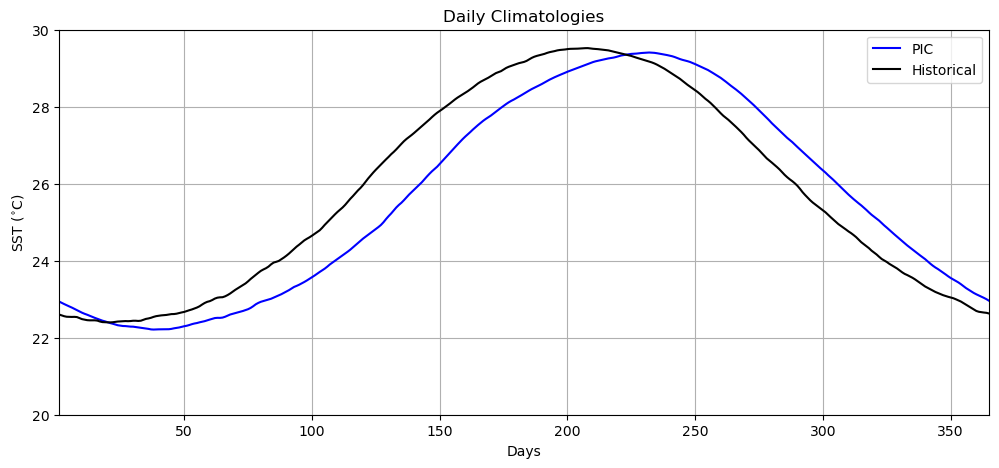

In [45]:
plt.figure(figsize=(12,5))
pic_clim.mean(('yh','xh')).plot(color='blue', label='PIC')
hclim_ptime.mean(('yh','xh')).plot(color='k', label='Historical')
#(hclim_ptime-pic_clim).mean(('yh','xh')).plot(color='grey', linestyle='dashed', label='diff')
plt.grid()
plt.xlim(1,365)
plt.ylim(20, 30)
plt.ylabel(r'SST ($^{\circ}$C)')
plt.xlabel('Days')
plt.title('Daily Climatologies')
plt.legend();

In [55]:
hist_gom.time

<xarray.DataArray 'time' (time: 60265)> Size: 482kB
array(['1850-01-01T00:00:00.000000000', '1850-01-02T00:00:00.000000000',
       '1850-01-03T00:00:00.000000000', ..., '2014-12-29T00:00:00.000000000',
       '2014-12-30T00:00:00.000000000', '2014-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 482kB 1850-01-01 1850-01-02 ... 2014-12-31

In [86]:
pc_ext = pic_clim.drop_vars('time').expand_dims({'dayofyear':hist_clim.dayofyear.values})

In [87]:
pc_ext.data

array([[[[       nan,        nan,        nan, ..., 25.739817 ,
          25.744434 , 25.753057 ],
         [       nan,        nan,        nan, ..., 25.648613 ,
          25.66503  , 25.68664  ],
         [       nan,        nan,        nan, ..., 25.583452 ,
          25.634235 , 25.649979 ],
         ...,
         [       nan,        nan,        nan, ..., 15.581468 ,
          20.364218 , 22.870811 ],
         [       nan,        nan,        nan, ..., 14.2212   ,
          19.479033 , 22.718323 ],
         [       nan,        nan,        nan, ..., 12.716822 ,
          15.840177 , 21.857286 ]],

        [[       nan,        nan,        nan, ..., 25.718906 ,
          25.724287 , 25.733791 ],
         [       nan,        nan,        nan, ..., 25.628403 ,
          25.64516  , 25.666441 ],
         [       nan,        nan,        nan, ..., 25.559576 ,
          25.611044 , 25.62648  ],
         ...,
         [       nan,        nan,        nan, ..., 15.530997 ,
          20.322744 , 22.

In [84]:
hist_gom.groupby('time.dayofyear') - pic_clim.drop_vars('time').expand_dims({'dayofyear':hist_clim.dayofyear.values})

ValueError: Chunks do not add up to shape. Got chunks=((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), (1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 40), (23,), (40,)), shape=(366, 365, 23, 40)

In [81]:
t = pic_clim.drop_vars('time').expand_dims({'dayofyear':hist_clim.dayofyear.values})

In [53]:
# Calculate anomalous SST (variable forcing = (internal variability + variable forcing) - internal variability)
anom = hist_gom.groupby('time.day') - pic_clim

ValueError: incompatible dimensions for a grouped binary operation: the group variable 'day' is not a dimension on the other argument with dimensions ('time', 'yh', 'xh')

In [ ]:
plt.figure(figsize=(12,5))
pic_clim.mean(('yh','xh')).plot(color='blue', label='PIC')
hist_clim.mean(('yh','xh')).plot(color='k', label='Historical')
anom.mean(('yh','xh')).plot(color='grey', linestyle='dashed', label='Anomaly')
plt.grid()
plt.xlim(1,365)
plt.ylabel(r'SST ($^{\circ}$C)')
plt.xlabel('Days')
plt.title('Daily Climatologies and Anomaly');

### Plot trend line and trend map

KeyboardInterrupt: 

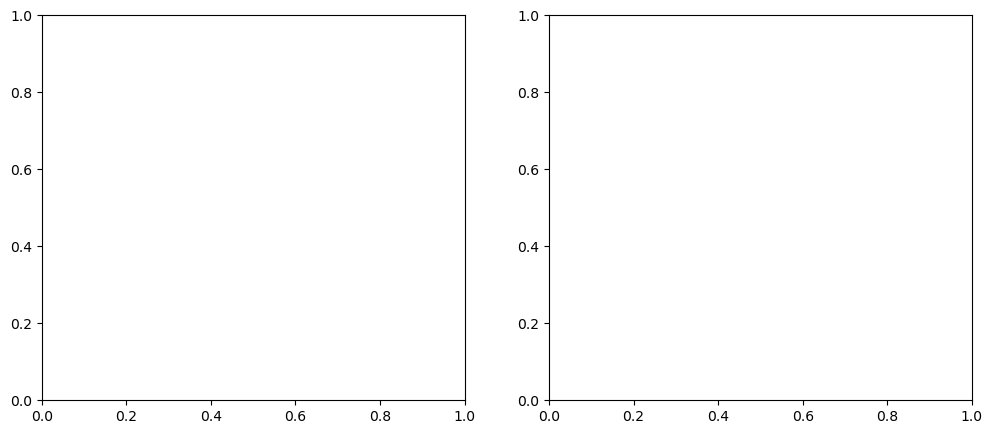

In [21]:
fig, (ax) = plt.subplots(1,2, figsize=(12,5))
sst_feng.sum(['xh', 'yh']).plot(ax=ax[0])
ax[0].grid()
sst_feng.mean(['xh', 'yh']).plot(ax=ax[1])
ax[1].grid();

In [23]:
sst_feng.time

<xarray.DataArray 'time' (time: 11680)> Size: 93kB
array([cftime.DatetimeNoLeap(1983, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1983, 1, 2, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1983, 1, 3, 12, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2014, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2014, 12, 31, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 93kB 1983-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds

In [24]:
#go off of spatial avg instead of sum so that we see trend line in regular ˚C, otherwise we're just adding ˚C
trend = linregress(np.arange(0,11680), sst_feng.mean(['xh', 'yh']).fillna(0.))

In [25]:
trend

LinregressResult(slope=7.079724082684583e-05, intercept=26.12317008836351, rvalue=0.09765834476059775, pvalue=3.749281161198154e-26, stderr=6.676392071291453e-06, intercept_stderr=0.045019032778959626)

In [26]:
#linear regression at every grid cell over time, so that we see trend rate in ˚C/yr at each grid pt
# Calculate the linear trend at each grid point
trend = sst_feng.groupby('time.year').mean('time').polyfit('year', deg=1)

In [27]:
trend

<xarray.Dataset> Size: 17kB
Dimensions:               (yh: 31, xh: 33, degree: 2)
Coordinates:
  * yh                    (yh) float64 248B 17.73 18.14 18.56 ... 30.24 30.67
  * xh                    (xh) float64 264B -97.75 -97.25 ... -82.25 -81.75
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, yh, xh) float64 16kB dask.array<chunksize=(2, 31, 33), meta=np.ndarray>

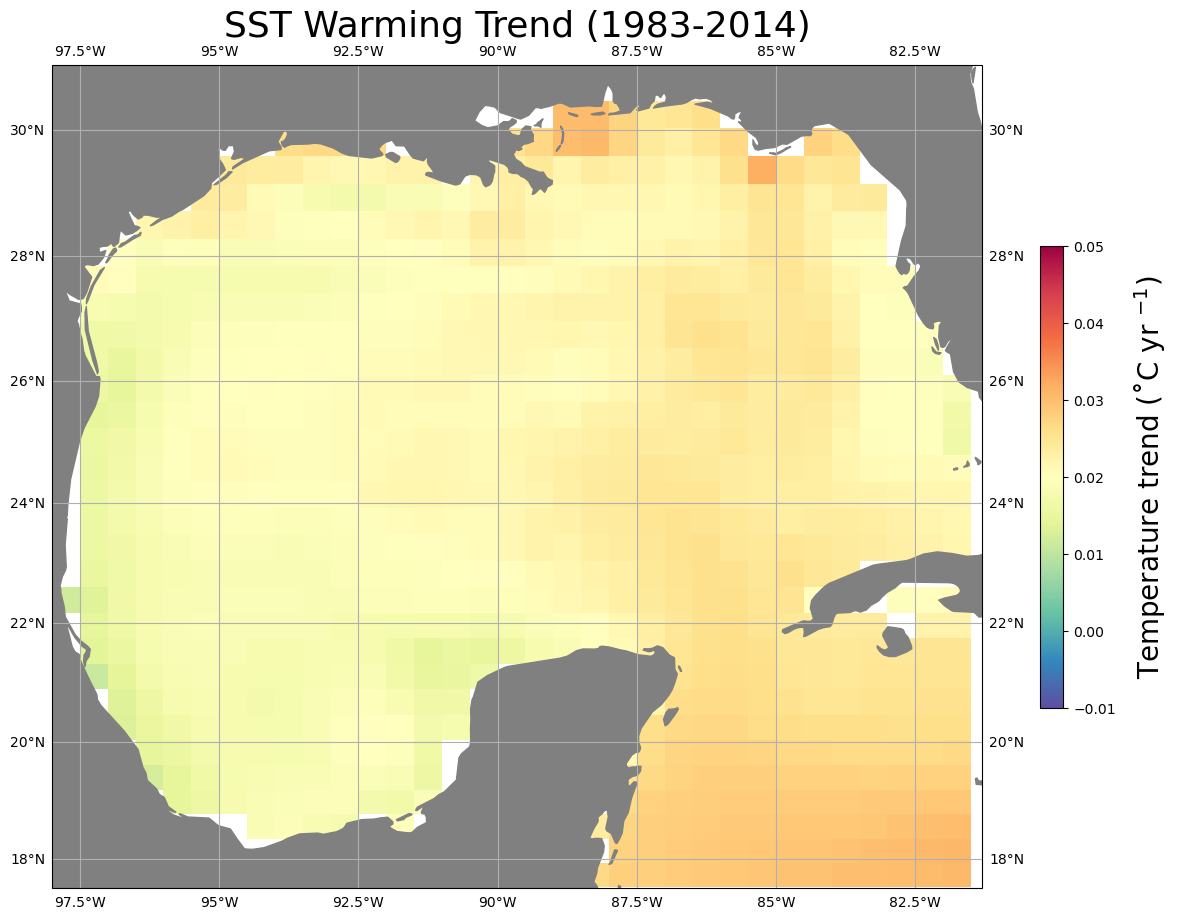

In [30]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81.3, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
da = trend.polyfit_coefficients[0]
im = ax.pcolormesh(da.xh, da.yh, da, transform=ccrs.PlateCarree(), 
                   cmap='Spectral_r', vmin=-0.01, vmax=0.05)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Temperature trend (˚C yr $^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('SST Warming Trend (1983-2014)', fontsize=26);

Similar spatial trend as noted in Feng's results (first line)

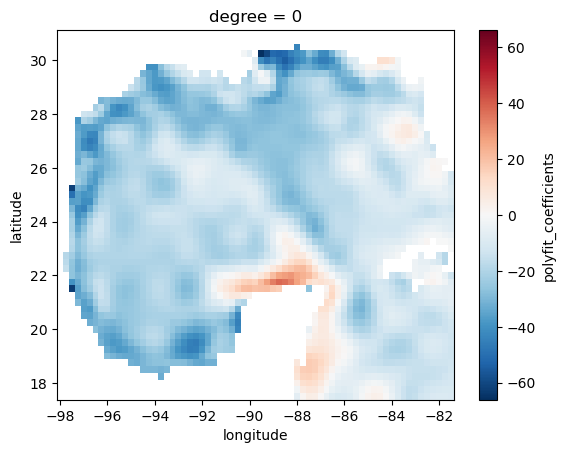

In [14]:
trend.polyfit_coefficients[1].plot()

In [61]:
trend_line = (trend[0]*np.arange(0,341880) + trend[1])

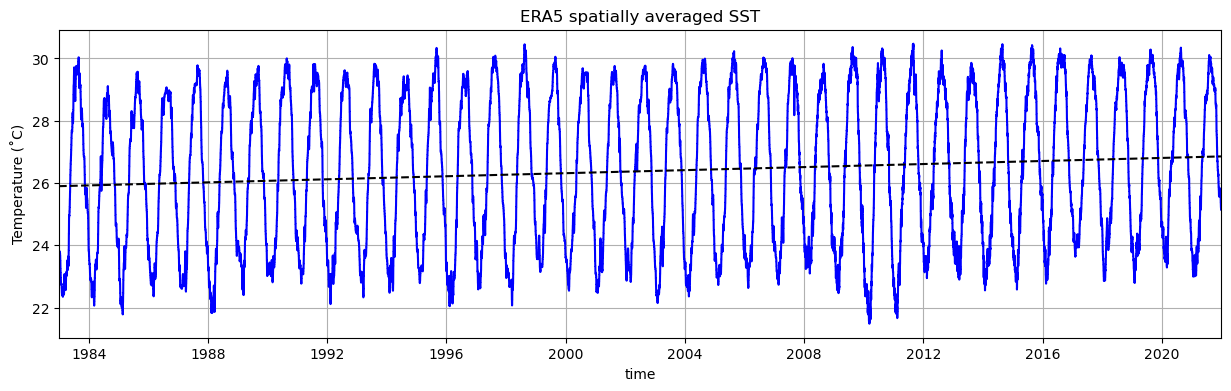

In [64]:
sst_feng.mean(['latitude', 'longitude']).plot(figsize=(15,4), color='blue')
plt.plot(sst_feng.time, trend_line, color='k', linestyle='dashed')
plt.grid()
plt.ylabel('Temperature (˚C)')
plt.xlim(sst_feng.time.sel(time='1983-01-01', method='nearest'), 
         sst_feng.time.sel(time='2021-12-31', method='nearest'))
plt.title('ERA5 spatially averaged SST');

In [68]:
print('Spatially averaged rate of SST increase over 1983-2021:', 
      (trend_line[-1] - trend_line[0]) / (2021-1983), 
      '˚C/yr')

Spatially averaged rate of SST increase over 1983-2021: 0.025146481519222164 ˚C/yr
